Found 10 images
Global Min: 0, Max: 255
Threshold: 169 (66.5% of range)

[1/10] 1.jpg
[2/10] 10.jpg
[3/10] 2.jpg
[4/10] 3.jpg
[5/10] 4.jpg
[6/10] 5.jpg
[7/10] 6.jpg
[8/10] 7.jpg
[9/10] 8.jpg
[10/10] 9.jpg


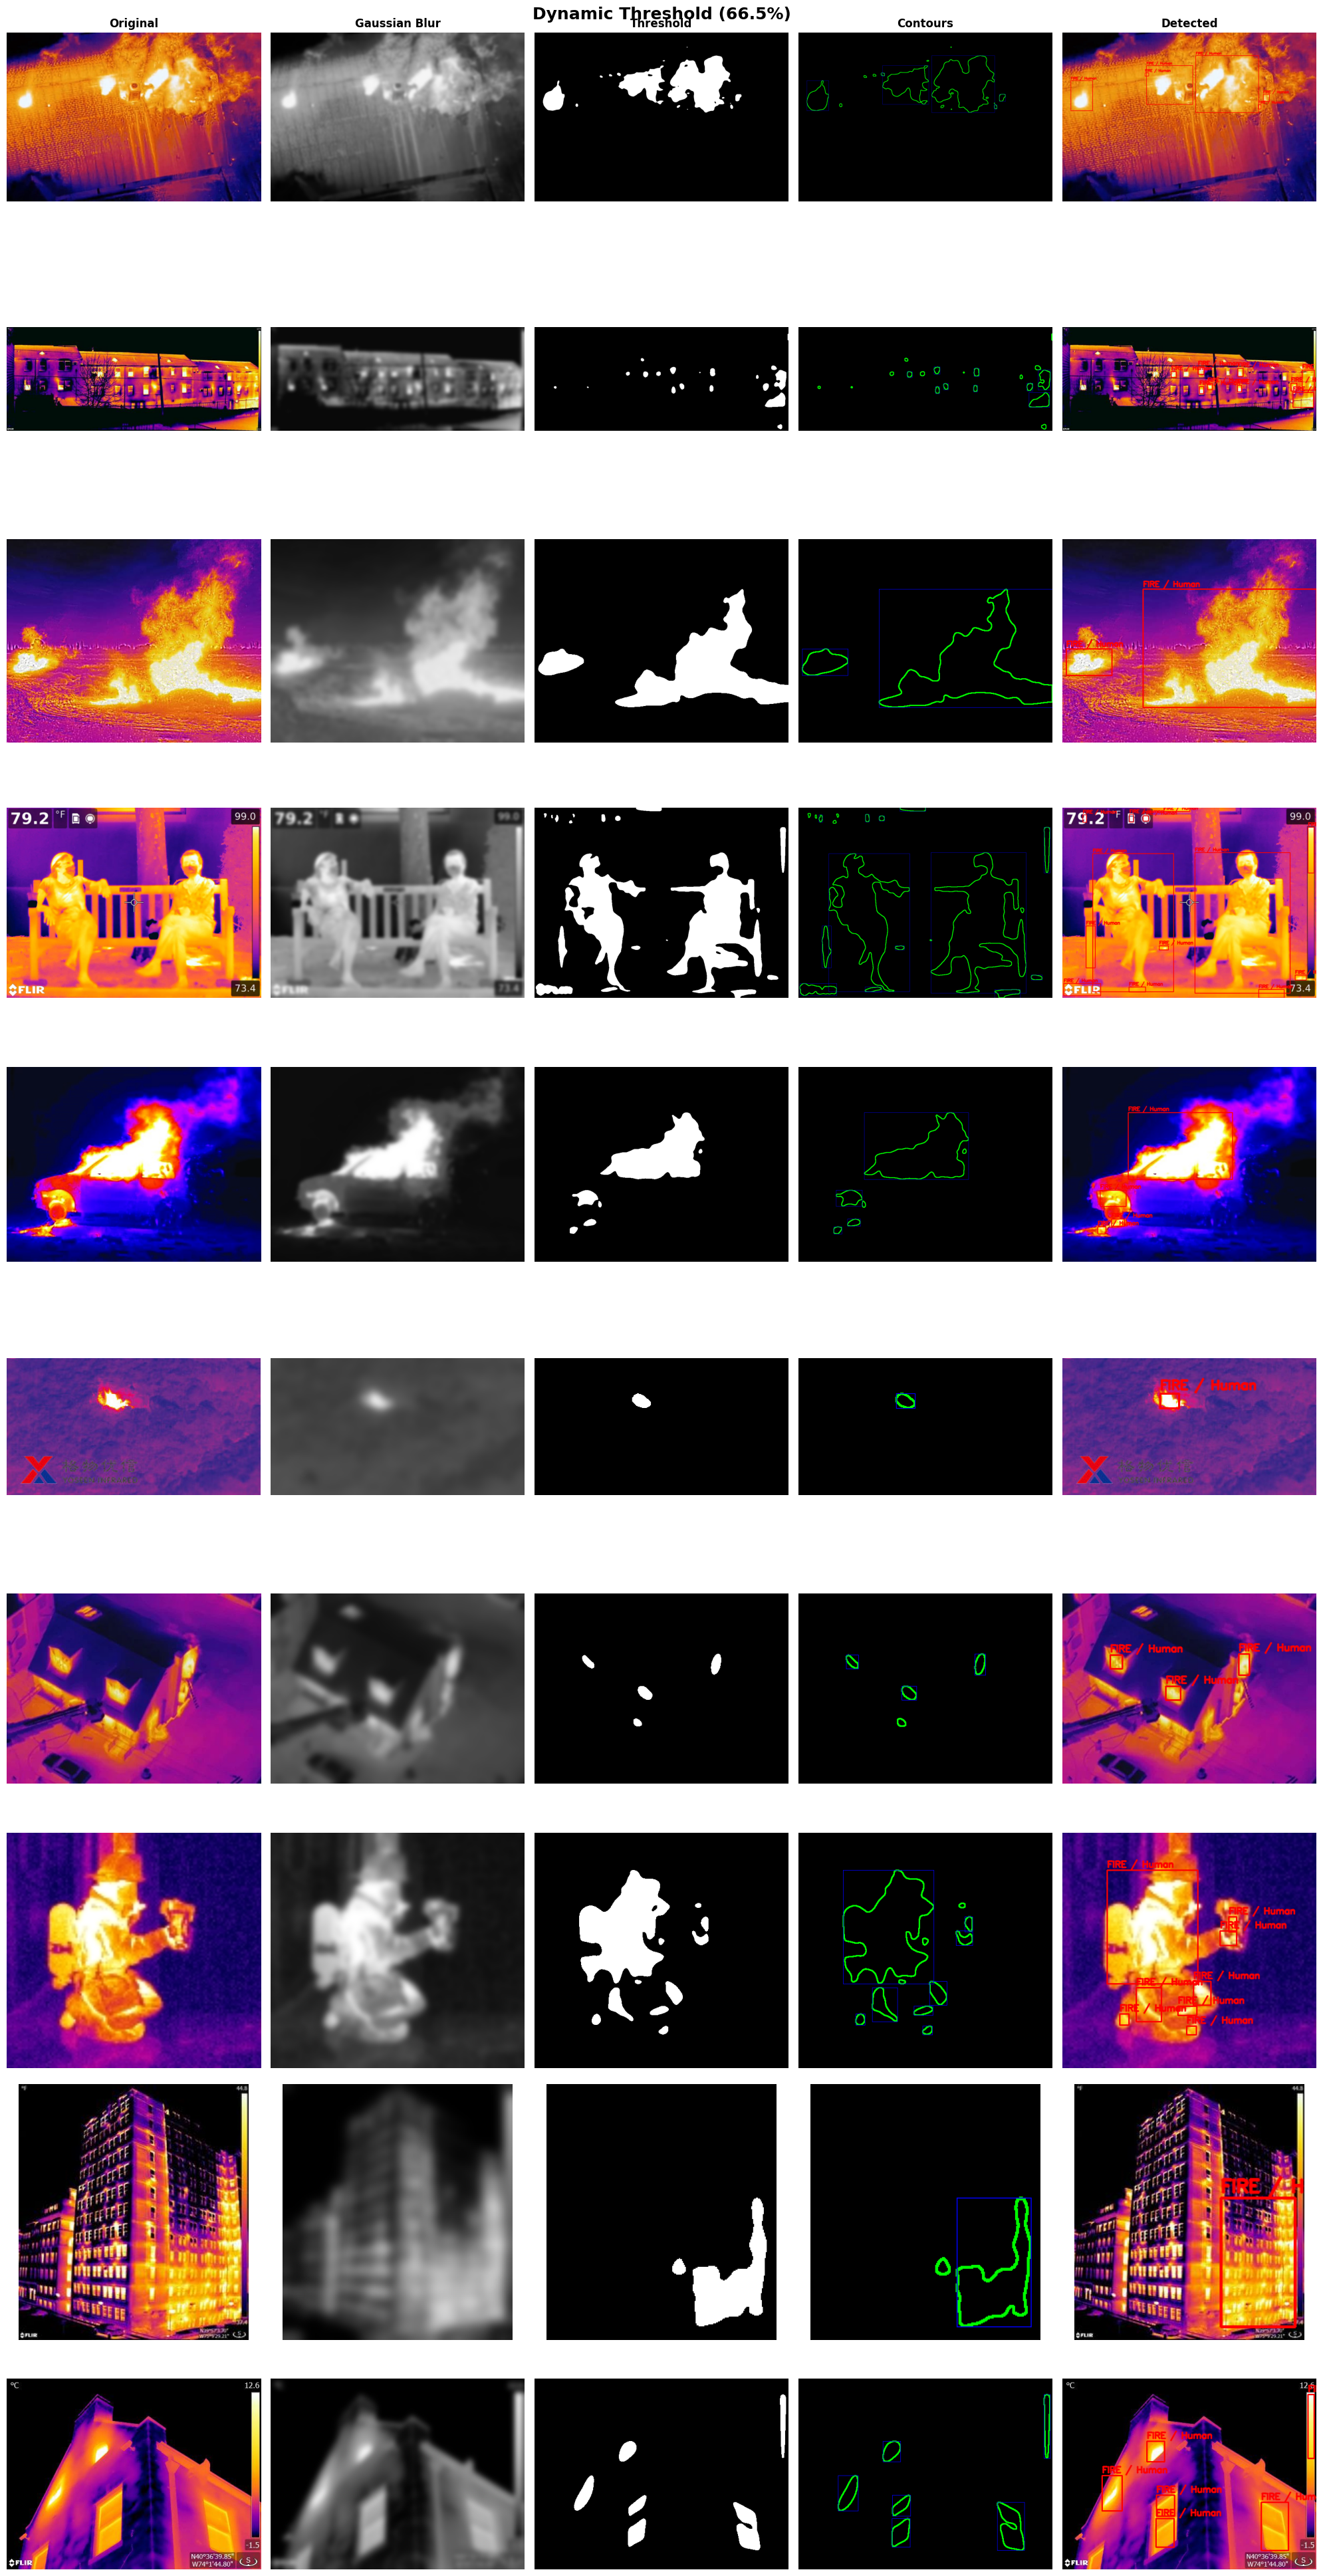


✓ Displayed 10 images


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def process_image(input_filename, threshold_value):
	image = cv2.imread(input_filename)
	if image is None:
		print(f"Error: '{input_filename}'")
		return None

	# Gaussian blur uygula
	gray_blur = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (35, 35), 0)
	
	# Threshold ve morfolojik işlem
	_, th = cv2.threshold(gray_blur, threshold_value, 255, cv2.THRESH_BINARY)
	mask = cv2.morphologyEx(th, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

	# Konturları bul ve filtrele
	contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	boxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) >= 200]

	# Görselleştirme panelleri oluştur
	display_blur = cv2.cvtColor(gray_blur, cv2.COLOR_GRAY2BGR)
	display_th = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
	
	display_contour = np.zeros_like(image)
	cv2.drawContours(display_contour, contours, -1, (0, 255, 0), 2)
	for x, y, w, h in boxes:
		cv2.rectangle(display_contour, (x, y), (x + w, y + h), (255, 0, 0), 1)
	
	display_fire = image.copy()
	for x, y, w, h in boxes:
		cv2.rectangle(display_fire, (x, y), (x + w, y + h), (0, 0, 255), 2)
		cv2.putText(display_fire, "FIRE / Human", (x, max(y - 6, 10)), 
		           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)

	# BGR to RGB
	panels = [cv2.cvtColor(p, cv2.COLOR_BGR2RGB) for p in 
	         [image, display_blur, display_th, display_contour, display_fire]]
	
	return panels, os.path.basename(input_filename)


def main(threshold_ratio=0.65):
	photos_dir = "Photos"
	
	if not os.path.exists(photos_dir):
		print(f"Error: '{photos_dir}' not found")
		return
	
	image_files = sorted([f for f in os.listdir(photos_dir) 
	                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
	
	if not image_files:
		print(f"No images found in '{photos_dir}'")
		return
	
	# Tüm görüntülerin min-max değerlerini topla
	all_mins, all_maxs = [], []
	for filename in image_files:
		img = cv2.imread(os.path.join(photos_dir, filename), cv2.IMREAD_GRAYSCALE)
		if img is not None:
			all_mins.append(np.min(img))
			all_maxs.append(np.max(img))
	
	# Global dinamik threshold hesapla
	global_min = min(all_mins)
	global_max = max(all_maxs)
	threshold_value = int(global_min + (global_max - global_min) * threshold_ratio)
	
	print(f"Found {len(image_files)} images")
	print(f"Global Min: {global_min}, Max: {global_max}")
	print(f"Threshold: {threshold_value} ({threshold_ratio*100}% of range)\n")
	
	# Tüm görüntüleri işle
	all_results = []
	for idx, filename in enumerate(image_files, 1):
		print(f"[{idx}/{len(image_files)}] {filename}")
		result = process_image(os.path.join(photos_dir, filename), threshold_value)
		if result:
			all_results.append(result)
	
	if not all_results:
		print("No images processed")
		return
	
	# Tek panelde göster
	titles = ['Original', 'Gaussian Blur', 'Threshold', 'Contours', 'Detected']
	fig, axes = plt.subplots(len(all_results), 5, figsize=(20, 4 * len(all_results)))
	fig.suptitle(f'Dynamic Threshold ({threshold_ratio*100}%)', fontsize=18, fontweight='bold')
	
	if len(all_results) == 1:
		axes = [axes]
	
	for row_idx, (panels, basename) in enumerate(all_results):
		for col_idx, (panel, title) in enumerate(zip(panels, titles)):
			ax = axes[row_idx][col_idx]
			ax.imshow(panel)
			if row_idx == 0:
				ax.set_title(title, fontsize=12, fontweight='bold')
			if col_idx == 0:
				ax.set_ylabel(basename, fontsize=10, rotation=0, labelpad=50, ha='right')
			ax.axis('off')
	
	plt.tight_layout()
	plt.show()
	print(f"\n✓ Displayed {len(all_results)} images")

if __name__ == "__main__":
	main(threshold_ratio=0.665)